In [19]:
import pandas as pd
import prophet as pr
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%cd -q ../..
from utils import util
%cd -q -

In [4]:
df_train=util.read_gasprediction_gas_data()
df_weather=util.read_gasprediction_weather_data()

In [5]:
df_train.index=pd.to_datetime(df_train.index)

In [12]:
df_mod=df_train[["margin"]].copy()
df_mod=df_mod.reset_index(level=0)
df_mod.head()

,day,margin
0,2011-10-01,-191914000.0
1,2011-10-02,-120660000.0
2,2011-10-03,-169770000.0
3,2011-10-04,-137430000.0
4,2011-10-05,-126892000.0


In [13]:
df_mod.rename(columns={"day":"ds","margin":"y"},inplace=True)
df_mod.head()

,ds,y
0,2011-10-01,-191914000.0
1,2011-10-02,-120660000.0
2,2011-10-03,-169770000.0
3,2011-10-04,-137430000.0
4,2011-10-05,-126892000.0


In [14]:
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      3653 non-null   datetime64[ns]
 1   y       2999 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.2 KB


In [15]:
m=pr.Prophet(yearly_seasonality=True,growth='linear')
m.add_country_holidays(country_name='DE')
m.fit(df_mod)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


# Forecast

,ds,yhat,yhat_lower,yhat_upper
0,2011-10-01,5.671611e+07,-6.277682e+07,1.868303e+08
1,2011-10-02,4.607516e+07,-8.361509e+07,1.862028e+08
2,2011-10-03,3.042970e+07,-1.017979e+08,1.605928e+08
3,2011-10-04,9.136258e+07,-4.904359e+07,2.302761e+08
4,2011-10-05,8.621200e+07,-5.207145e+07,2.231307e+08


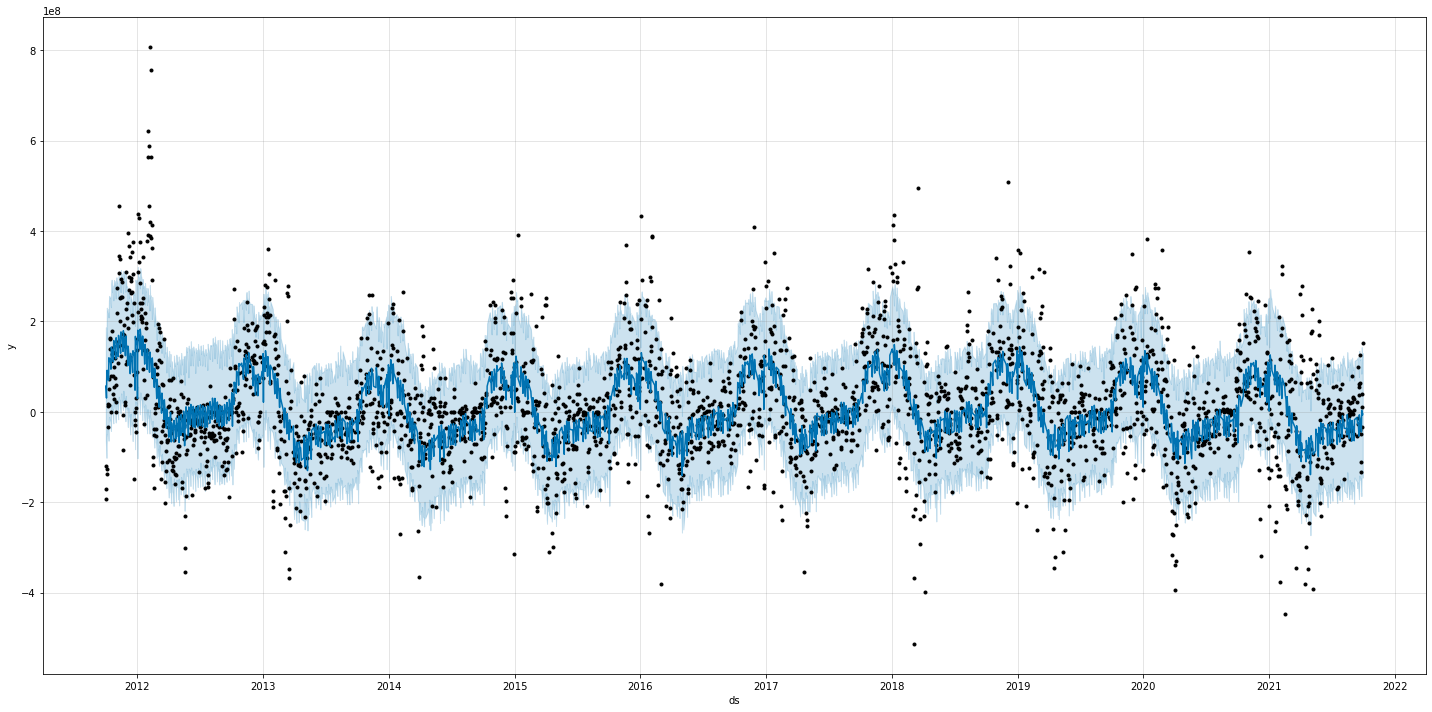

In [17]:
forecast = m.predict()
fig1 = m.plot(forecast,figsize=(20,10))
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

# Residuals

In [18]:
df_res=pd.merge(df_mod,forecast,on='ds')
df_res['residuals']=df_res['yhat'] - df_res['y']
df_res.head()

,ds,y,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christi Himmelfahrt,Christi Himmelfahrt_lower,Christi Himmelfahrt_upper,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,residuals
0,2011-10-01,-191914000.0,7.375897e+07,-6.277682e+07,1.868303e+08,7.375897e+07,7.375897e+07,0.0,0.0,0.0,...,-1.370019e+07,-1.370019e+07,-3.342673e+06,-3.342673e+06,-3.342673e+06,0.0,0.0,0.0,5.671611e+07,2.486301e+08
1,2011-10-02,-120660000.0,7.362395e+07,-8.361509e+07,1.862028e+08,7.362395e+07,7.362395e+07,0.0,0.0,0.0,...,-2.709404e+07,-2.709404e+07,-4.547468e+05,-4.547468e+05,-4.547468e+05,0.0,0.0,0.0,4.607516e+07,1.667352e+08
2,2011-10-03,-169770000.0,7.348892e+07,-1.017979e+08,1.605928e+08,7.348892e+07,7.348892e+07,0.0,0.0,0.0,...,1.894486e+07,1.894486e+07,2.628266e+06,2.628266e+06,2.628266e+06,0.0,0.0,0.0,3.042970e+07,2.001997e+08
3,2011-10-04,-137430000.0,7.335389e+07,-4.904359e+07,2.302761e+08,7.335389e+07,7.335389e+07,0.0,0.0,0.0,...,1.211619e+07,1.211619e+07,5.892496e+06,5.892496e+06,5.892496e+06,0.0,0.0,0.0,9.136258e+07,2.287926e+08
4,2011-10-05,-126892000.0,7.321887e+07,-5.207145e+07,2.231307e+08,7.321887e+07,7.321887e+07,0.0,0.0,0.0,...,3.673466e+06,3.673466e+06,9.319661e+06,9.319661e+06,9.319661e+06,0.0,0.0,0.0,8.621200e+07,2.131040e+08


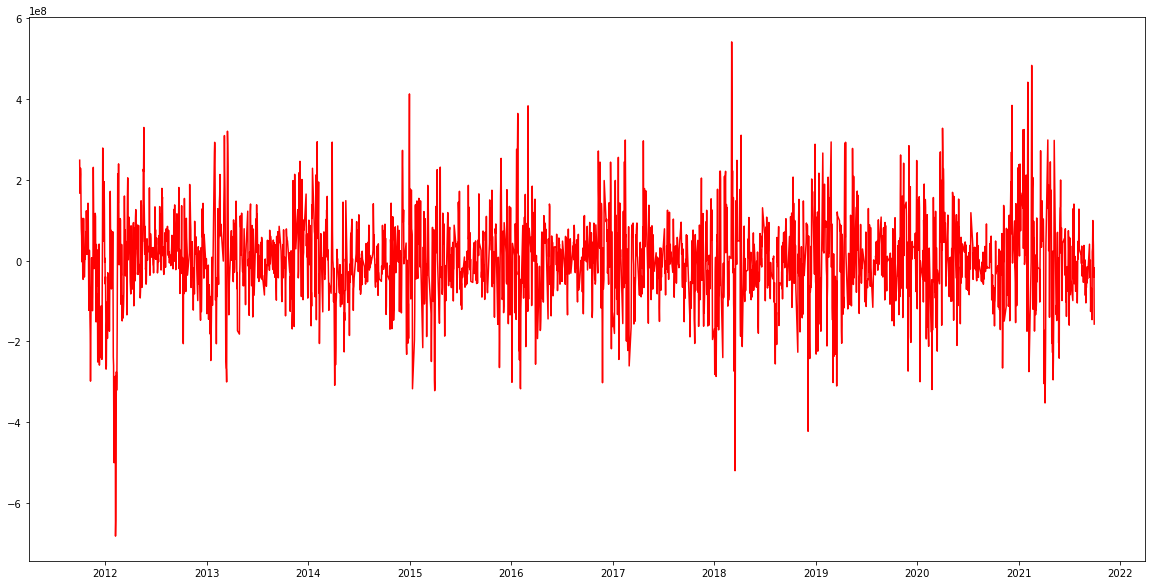

In [21]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(df_res['ds'],df_res['residuals'],'r')

# Components

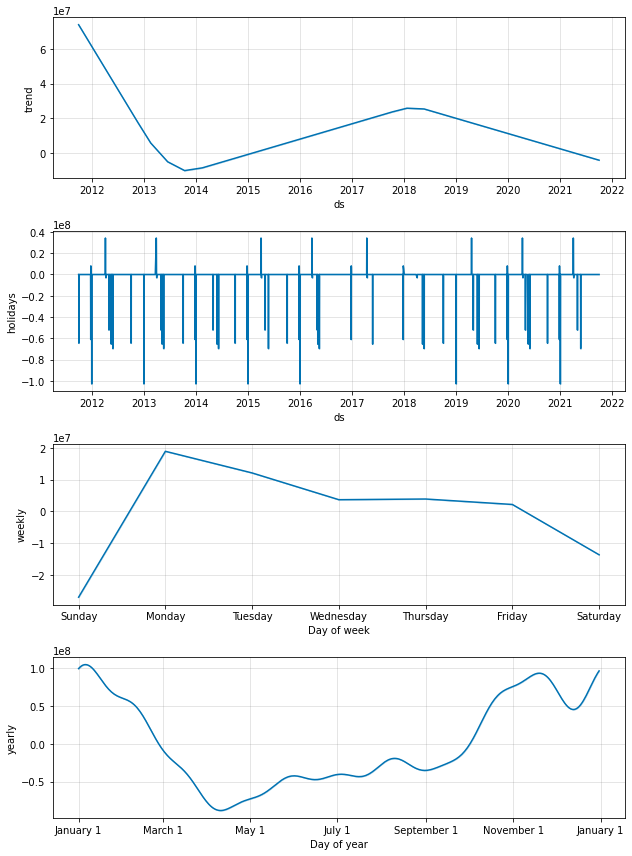

In [22]:
fig2 = m.plot_components(forecast)

# Cross Validation / Metrics

In [25]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

INFO:prophet:Making 15 forecasts with cutoffs between 2013-11-06 00:00:00 and 2020-09-30 00:00:00


  0%|          | 0/15 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2013-11-07,1.247130e+08,-9.308970e+06,2.544488e+08,-121903000.0,2013-11-06
1,2013-11-08,1.173402e+08,-1.876666e+07,2.547188e+08,17280000.0,2013-11-06
2,2013-11-09,9.911122e+07,-2.612521e+07,2.226651e+08,93270000.0,2013-11-06
3,2013-11-10,1.146998e+08,-2.171728e+07,2.444276e+08,141008000.0,2013-11-06
4,2013-11-11,1.589563e+08,1.808584e+07,2.777188e+08,259383000.0,2013-11-06


In [26]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

INFO:prophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,smape,coverage
0,36 days,1.206992e+16,1.098632e+08,8.475150e+07,0.707178,1.016834,0.809719
1,37 days,1.184589e+16,1.088388e+08,8.428869e+07,0.706770,1.016380,0.811997
2,38 days,1.188471e+16,1.090170e+08,8.492688e+07,0.710302,1.032745,0.809112
3,39 days,1.231123e+16,1.109560e+08,8.670428e+07,0.722278,1.050586,0.794989
4,40 days,1.218948e+16,1.104060e+08,8.594986e+07,0.729721,1.056109,0.797115


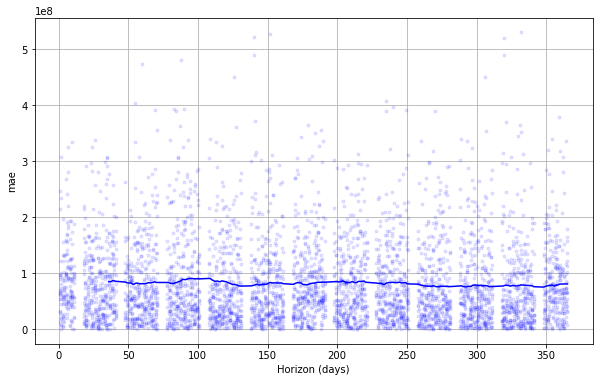

In [28]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mae')